In [1]:
import torch
import math
import matplotlib.pyplot as plt

In [2]:
# autograd globally off
torch.set_grad_enabled(False)

### Layer Modules

In [3]:
class Module(object):
    """
    Base class to be inherited by other modules
    """
    def __init__(self):
        self.parameters = []

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

In [4]:
class Parameter(object):
    def __init__(self, data):
        # data is used to store weight and bias
        self.data = data
        # grad is used to store gradient of weight and bias
        self.grad = None

In [5]:
class Linear(Module):
    """
    Implements linear layer, with or without bias
    Parameters: shape: (in_size, out_size)
    bias: whether there is bias in the Linear, defaut value is true
    initialization: uniform 
    """
    def __init__(self, shape, bias=True, initialization='uniform',**kwargs):
        super().__init__()
        # using pytorch default weight initialization
        
        self.weights = Parameter(torch.Tensor(shape[0],shape[1]))
        if initialization=='uniform':
            init_range = 1. / math.sqrt(shape[0])
            self.weights.data=self.weights.data.uniform_(-init_range, init_range)
            
        self.weights.grad = torch.zeros(shape)
        
        if bias:
            # default bias initialization
            self.bias = Parameter(torch.Tensor(shape[1]))
            self.bias.grad = torch.zeros(shape[1])
            if initialization=='uniform':
                self.bias.data=self.bias.data.uniform_(-init_range, init_range) 
        else:
            self.bias = None
            
            
    def forward(self, x):
        # Returns tensor of size N * out_features
        self.x = x
        output=x.matmul(self.weights.data)
        if self.bias is not None:
            output+=self.bias.data
        return output

    def backward(self, grad_output):
        # grad_output: gradient from the lower layers
        # Returns tensor of size N * in_features, computes gradient wrt the weights
        
        
        self.weights.grad += torch.mm(self.x.t(),grad_output)
#         torch.mm(a,b)
        grad_input = torch.mm(grad_output,self.weights.data.t())
#         grad_input = grad_output.matmul(self.weights.data.t())
        
        if self.bias is not None:
            self.bias.grad += torch.einsum('ij->j', grad_output)
        return grad_input

### Activation functions

In [6]:
class ReLU(Module):
    """
    Implements Rectifier Linear Unit activation
    Only positive inputs are back-propagated
    """
    def forward(self, x):
        #saving x for the backpropagation
        self.x = x
        # return non-negative x
        return torch.max(torch.empty(self.x.size()).zero_(),x)

    def backward(self, eta):
        eta[self.x<=0]=0
        return eta

In [7]:
class Tanh(Module):
    """
    Implements tanh activation
    The derivative of tanh(x) is 1 - tanh(x) ** 2
    """
    def forward(self, x):
        ex = torch.exp(x)
        esx = torch.exp(-x)
        self.y = (ex - esx) / (ex + esx)
        return self.y

    def backward(self, eta):
        return eta*(1-self.y**2)

In [8]:
#Sigmoid Activation Module
class  Sigmoid(Module):
        
    
    def  forward(self , s):
        
        #Saving s for the backward
        self.s=s
        
        return 1/(1+math.exp(1)**(-self.s))
        
    def backward(self , gradx):
        
        #Computing the gradient with respect to s
        #∇s sigmoid(s) = sigmoid(s)*(1-sigmoid(s))
        grads=gradx*((1/(1+math.exp(1)**(-self.s)))*(1-1/(1+math.exp(1)**(-self.s)))) 
        
        return grads

### Loss functions

In [9]:
class MSELoss(Module):
    
    def __init__(self):
        super().__init__()

    def __call__(self, pred_, target):
        
        return self.forward(pred_, target)

    def forward(self, pred_, target):
        
        return torch.mean((pred_ - target)**2).item()

    def backward(self, pred_, target):
        #Computing the gradient of the loss with respect to input
        
        return 2*(pred_ - target)/target.size(0)

### Optimizer

In [10]:
class SGD:
    def __init__(self, layers, learning_rate):
        self.layers = layers
        self.learning_rate = learning_rate

    def step(self):
        
        for layer in self.layers:
            #if the Layer is Linear, update the weight and bias
            if isinstance(layer, Linear):
                # update the weight and bias
                layer.weights.data=layer.weights.data-self.learning_rate * layer.weights.grad
                layer.bias.data=layer.bias.data-self.learning_rate * layer.bias.grad

### Concatenate different layers

In [11]:
class Sequential(Module):
    """
    Implements sequential layer to combine multiple modules given in *args
    # Usage example: Sequential(layer1, layer2, layer3)
    """
    def __init__(self, layer_configures, model_name):
        self.layers = []
        self.model_name=model_name
        for config in layer_configures:
            self.layers.append(self.createLayer(config))
#         self.layers = layers
    
    
    def createLayer(self, config):
        t = config['type']
        if t == 'Linear':
            layer = Linear(**config)
        elif t == 'ReLU':
            layer = ReLU()
        elif t == 'Tanh':
            layer = Tanh()
        elif t == 'Sigmoid':
            layer = Sigmoid()
        else:
            raise TypeError
        return layer

    def __call__(self, x):
        return self.forward(x)

    def zero_grad(self):
        for layer in self.layers:
            #if the Layer is Linear, update the gradient of weight and bias to zeros
            if isinstance(layer, Linear):
                # update the gradient of weight and bias to zeros
                layer.weights.grad.zero_()
                layer.bias.grad.zero_()

    def forward(self, x):
        
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, eta):
        
        for layer in reversed(self.layers):
            eta = layer.backward(eta)
        return eta

### generate training and testing dataset

In [12]:
def generate_set(num):
    """
    generate training data and testing data
    :param num: the number of pairs of random points and labels that you want to generate.
    :return: random_points: the random point in [0,1]
             targets:  whether the point is in the circle
    :return eaxmple: num=1, tensor([[0.8247, 0.7978]]), tensor([[0.]])
    """
#   using pytorch tensor operation
#   return the generated random points and labels
    random_points = torch.rand((num, 2))
    # check if the point is in the circle centered at (0.5,0.5) of radius 1/sqrt(2*math.pi)
    targets=torch.Tensor([int(pow(x[0]-0.5,2)+pow(x[1]-0.5,2)<1/(2*math.pi)) for x in random_points]).view(-1,1)
    return random_points, targets

In [186]:
def plot_result(input_data, pred, true_label, model_name):
    """
    plot the points and the predicted result
    param input_data: points with x and y
    param pred: predicted result
    param target: the true label
    return the image drawing the predicted result
    """
    # 0 is the error predicted, 1 is the correct predicted
    error_data=(pred-true_label).eq(0).float()
    # in pred, 0 is outside the circle, 1 is inside the circle.
    # after +1: 1 is outside the circle, 2 is inside the circle.
    # after mul: 1 is outside the circle, 2 is inside the circle, 0 is false predicted
    target=(pred+1).mul(error_data)
#     fig, ax = plt.subplots()
    cdict = {1: 'green', 2: 'blue', 0: 'red'}
    label_dict= {1: 'Outside the circle', 2: 'Inside the circle', 0: 'Error'}
    fig, ax = plt.subplots()
    for g in torch.unique(target):
        ix = torch.where(target.view(target.shape[0])==g)
        ax.scatter(input_data[:,0][ix], 
                   input_data[:,1][ix], 
                   c = cdict[g.item()], 
                   label = label_dict[g.item()])
    
    ax.legend()
    plt.axis("equal")
    plt.savefig(model_name+'randompoint_target.png')
    plt.show()   

### Training function

In [14]:
def train_model(model, train_input, train_target,test_input, test_target,learning_rate_list, batch_size=25, n_epochs=700, loss=MSELoss()):
    """
    Train model
    :param model: Sequence instance
    :param train_input: tensor of size [size, 2] with coordinates x,y of the samples
    :param train_target: tensor of size [size,1] with labels of the samples
    :param test_input: tensor of size [size, 2] with coordinates x,y of the samples
    :param test_target: tensor of size [size,1] with labels of the samples
    :param batch_size: (int) size of batch to perform SGD
    :param n_epochs: (int) number of iterations along the whole train set
    :param loss: loss function instance
    :param learning_rate: (float) which is used to perform SGD
    :return: my_loss: (list) values of loss along the epochs
    """
    # train model
    # time record
    start_time = time.time()
    train_loss_history=[]
    train_accuracy=[]
    test_loss_history=[]
    test_accuracy=[]
    
    sample_size = train_input.size(0)
    # reduce the learning rate when training epoch is halfway 
    # so that the training loss can continue to decrease
    for epoch in range(n_epochs):
        for x in learning_rate_list:
            if epoch==x[1]:
                learning_rate=x[0]
        sgd = SGD(model.layers, learning_rate)
        cumulative_loss = 0
        for n_start in range(0, sample_size, batch_size):
            # resetting the gradients
            model.zero_grad()
            output = model(train_input[n_start : n_start + batch_size])
            # accumulating the loss over the mini-batches
            cumulative_loss += loss(output, train_target[n_start : n_start + batch_size]) * batch_size
            # calculating the gradient of the loss wrt final outputs
            loss_grad = loss.backward(output, train_target[n_start : n_start + batch_size])
            # propagating it backward
            model.backward(loss_grad)
            # updating the parameters
            sgd.step()
        
        # get the training loss and accuracy
        train_pred=model(train_input) 
        train_loss=loss(train_pred,train_target)
        train_loss_history.append(train_loss)
        train_accuracy_result=compute_accuracy(train_target,train_pred)
        train_accuracy.append(train_accuracy_result)

        # get the testing loss and accuracy
        test_pred=model(test_input)
        test_loss=loss(test_pred,test_target)
        test_loss_history.append(test_loss)
        test_accuracy_result=compute_accuracy(test_target,test_pred)
        test_accuracy.append(test_accuracy_result)
        
        #Printing the results of the current iteration
        print(model.model_name," :the average training loss at epoch {} is {}".format(epoch+1,(cumulative_loss / sample_size)),end='\r')
    print("\r")
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    print("The final train accuracy is",compute_accuracy(train_target,train_pred))
    print("The final test accuracy is ", compute_accuracy(test_target,test_pred))
    #Plotting the train and test loss and accuracy figure

    #Setting-up the plot
    plt.figure(figsize=(15,8))

    ax1 = plt.subplot(1,2,1)

    ax2 = plt.subplot(1,2,2)

    #Drawing and labeling the curves
    ax1.plot(train_loss_history, label="Training Loss")
    ax1.plot(test_loss_history, label="Test Loss")

    #Adding the title and axis labels
    ax1.set_title('Train VS Test Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()

#     #Saving the plot
#     ax1.figure.savefig(model.model_name+'loss.png')


    #Drawing and labeling the curves
    ax2.plot(train_accuracy, label="Train Accuracy")
    ax2.plot(test_accuracy, label="Test Accuracy")

    #Adding the title and axis labels
    ax2.set_title('Train VS Test Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    #Saving the plot
#     ax2.figure.savefig(model.model_name+'accuracy.png')
    plt.savefig(model.model_name+'accuracy_loss.png')
    plt.show()


def compute_accuracy(true_target, predicted):
    return (true_target-(predicted>0.5).float()).eq(0).float().mean().item()
    

### Training the model

model1  :the average training loss at epoch 2500 is 0.0037891892614993596
The final train accuracy is 0.9950000047683716
The final test accuracy is  0.9789999723434448


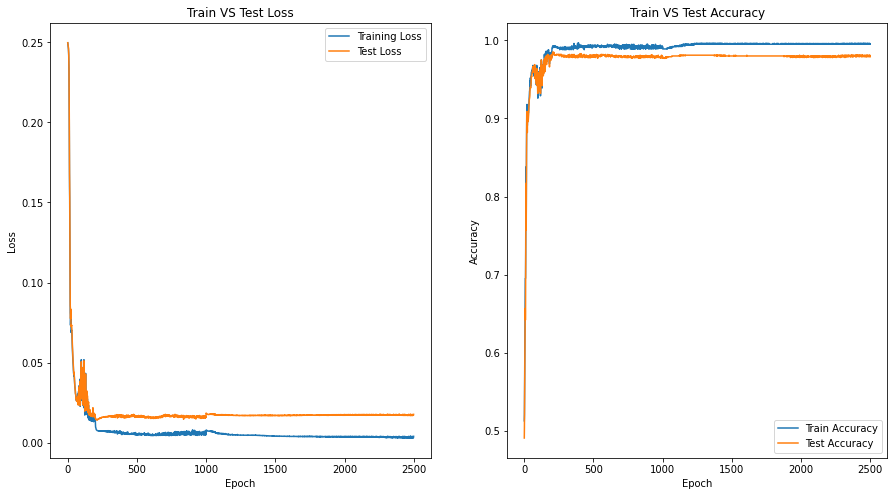

In [15]:
sample_size = 1000
batch_size=25
n_epochs=2500
# when the traing begin, the learning rate is 0.1; 
# After 200 epoch, the learning rate becomes 0.03
# Then after 1000 epoch, the learning rate becomes 0.01
learning_rate=[(0.1,0),(0.03,200),(0.01,1000)]


train_input, train_target = generate_set(sample_size)
test_input, test_target = generate_set(sample_size)
# train the model with ReLU
layers = [
    {'type': 'Linear', 'shape': (2, 25)},
    {'type': 'ReLU'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'ReLU'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'ReLU'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'ReLU'},
    {'type': 'Linear', 'shape': (25, 1)}
]

model = Sequential(layers,'model1')

train_model(model, train_input, train_target,test_input, test_target, learning_rate, batch_size, n_epochs, loss=MSELoss())

In [16]:
# draw the predicting plot
# set the threshold to 0.5
test_pred_1=(model(test_input)>0.5).float()

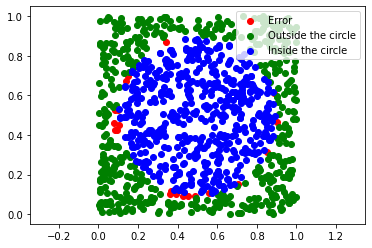

In [187]:
plot_result(test_input, test_pred_1, test_target, 'model1') 

model2  :the average training loss at epoch 2500 is 0.008535619314352516 :the average training loss at epoch 947 is 0.014247244653233793  :the average training loss at epoch 1091 is 0.01124041965304059 :the average training loss at epoch 1625 is 0.010136295128177153
The final train accuracy is 0.9940000176429749
The final test accuracy is  0.984000027179718


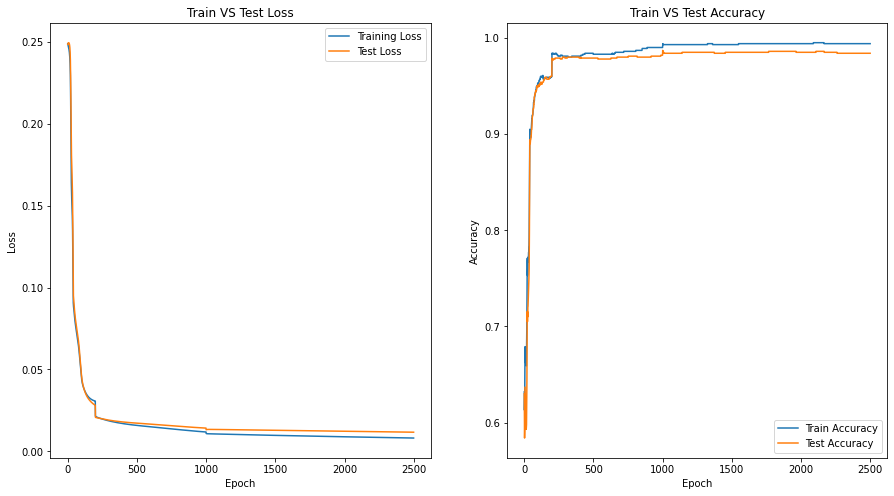

In [18]:
# train the model with Tanh
layers_2 = [
    {'type': 'Linear', 'shape': (2, 25)},
    {'type': 'Tanh'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'Tanh'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'Tanh'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'Tanh'},
    {'type': 'Linear', 'shape': (25, 1)}
]

model_2 = Sequential(layers_2,'model2')

train_model(model_2, train_input, train_target,test_input, test_target, learning_rate, batch_size, n_epochs, loss=MSELoss())

In [19]:
# draw the predicting plot
# set the threshold to 0.5
test_pred_2=(model_2(test_input)>0.5).float()

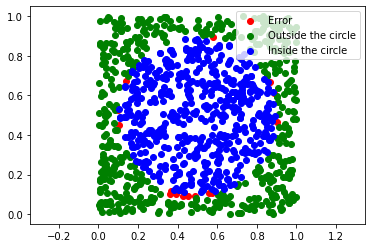

In [188]:
plot_result(test_input, test_pred_2,test_target, 'model2') 

model3  :the average training loss at epoch 2500 is 0.024392789974808694
The final train accuracy is 0.9850000143051147
The final test accuracy is  0.9800000190734863


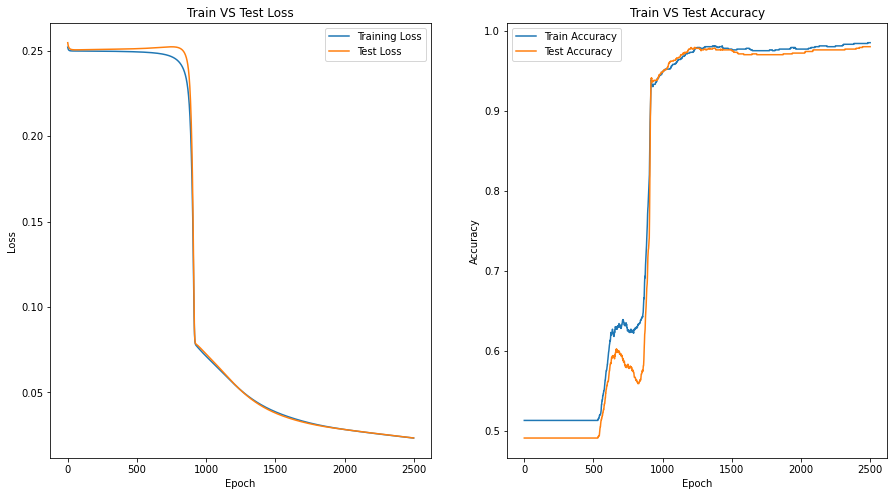

In [21]:
learning_rate_3=[(0.1,0)]
# train the model with Tanh
layers_3 = [
    {'type': 'Linear', 'shape': (2, 25)},
    {'type': 'Tanh'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'Sigmoid'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'Sigmoid'},
    {'type': 'Linear', 'shape': (25, 25)},
    {'type': 'Sigmoid'},
    {'type': 'Linear', 'shape': (25, 1)}
]

model_3 = Sequential(layers_3,'model3')

train_model(model_3, train_input, train_target,test_input, test_target, learning_rate_3, batch_size, n_epochs, loss=MSELoss())

In [22]:
# draw the predicting plot
# set the threshold to 0.5
test_pred_3=(model_3(test_input)>0.5).float()

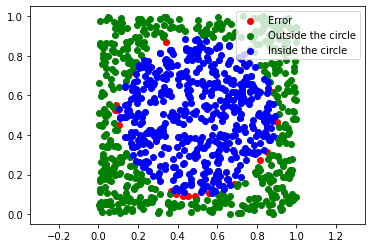

In [189]:
plot_result(test_input, test_pred_3,test_target, 'model3') 